In [1]:
import os


from typing import List, Dict

import re
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

import cohere
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone, ServerlessSpec

from tqdm import tqdm


API keys:

In [2]:
from dotenv import load_dotenv
load_dotenv(override=True)

# Replace with your own PineCone API KEY
PINECONE_API_KEY = os.environ.get("PINECONE_API_KEY", "") 

# Replace with your own Cohere API KEY
COHERE_API_KEY = os.environ.get("COHERE_API_KEY", "")

In [3]:
kb_path = './RAG_data/KB_data.csv'
whatsapp_chats = pd.read_csv(kb_path)

In [4]:
whatsapp_chats.head()

,msg_id,conv_id,conv_turn,sender_user_id,receiver_user_id,sent_at,text,answer
0,da909b73-688c-47fe-8c51-ce2f122a2736,chat:u_barbara_u_maayan_student_magshimim,1,u_maayan_student_magshimim,u_barbara,2025-01-06 17:37:39,"Hi, if it's possible to be a few minutes late,...","Yes, yes\nOne minute\nMaayan, something embarr..."
1,ddb46ea7-b3a7-4803-8404-423c49ccfbca,chat:u_barbara_u_maayan_student_magshimim,2,u_barbara,u_maayan_student_magshimim,2025-01-06 17:41:31,"Yes, yes\nOne minute\nMaayan, something embarr...","Okay\nRegarding homework 10, I got stuck debug..."
2,0c090651-7983-4a69-938a-0a53d41ce470,chat:u_barbara_u_maayan_student_magshimim,3,u_maayan_student_magshimim,u_barbara,2025-01-06 17:51:04,"Okay\nRegarding homework 10, I got stuck debug...","There's a part, one minute\nCheck if this is it"
3,bf35a2dd-5444-484d-99ff-b57ab7b20c2c,chat:u_barbara_u_maayan_student_magshimim,4,u_barbara,u_maayan_student_magshimim,2025-01-06 18:24:15,"There's a part, one minute\nCheck if this is it","I just got a moment to write this, sorry"
4,0db5bc6f-179e-46c1-8ba0-6c2f3e296082,chat:u_barbara_u_maayan_student_magshimim,5,u_maayan_student_magshimim,u_barbara,2025-01-06 18:24:21,"I just got a moment to write this, sorry","Oh, ugh, I don't have any messages on WhatsApp..."


## **Preprocessing & Embedding the data**

In [5]:
def load_and_embedd_dataset(
        dataset: DataFrame,
        model: SentenceTransformer = SentenceTransformer('all-MiniLM-L6-v2'),
) -> DataFrame:
    """
    Return a dataset with  column of embedd text field using a sentence-transformer model
    Args:
        dataset_name: The name of the dataset to load
        model: The model to use for embedding
    Returns:
        tuple: A Dataset containing the new column of the the embeddings
    """

    print("Loading and embedding the dataset")

    # build the text we embed
    dataset["doc_text"] = (
        dataset["sender_user_id"] + ": " + dataset["text"].fillna("") + "\n" +
        dataset["receiver_user_id"] + ": " + dataset["answer"].fillna("")
    )

    # compute embeddings as numpy array [n_rows, dim]
    embeddings = model.encode(
        dataset["doc_text"].tolist(),
        batch_size=32,
        convert_to_numpy=True,
        show_progress_bar=True
    )

    dataset["embedding"] = list(embeddings)

    print("Done!")
    return dataset, embeddings

In [6]:
EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
model_emb = SentenceTransformer(EMBEDDING_MODEL)

In [7]:
kb_df_all,embeddings = load_and_embedd_dataset(whatsapp_chats, model_emb)
kb_df_all.head()

Loading and embedding the dataset


Batches:   0%|          | 0/74 [00:00<?, ?it/s]

Batches: 100%|██████████| 74/74 [00:05<00:00, 14.23it/s]

Done!


,msg_id,conv_id,conv_turn,sender_user_id,receiver_user_id,sent_at,text,answer,doc_text,embedding
0,da909b73-688c-47fe-8c51-ce2f122a2736,chat:u_barbara_u_maayan_student_magshimim,1,u_maayan_student_magshimim,u_barbara,2025-01-06 17:37:39,"Hi, if it's possible to be a few minutes late,...","Yes, yes\nOne minute\nMaayan, something embarr...","u_maayan_student_magshimim: Hi, if it's possib...","[-0.071226135, -0.0022128718, 0.04721657, -0.0..."
1,ddb46ea7-b3a7-4803-8404-423c49ccfbca,chat:u_barbara_u_maayan_student_magshimim,2,u_barbara,u_maayan_student_magshimim,2025-01-06 17:41:31,"Yes, yes\nOne minute\nMaayan, something embarr...","Okay\nRegarding homework 10, I got stuck debug...","u_barbara: Yes, yes\nOne minute\nMaayan, somet...","[-0.11889872, 0.0334969, 0.03657475, -0.058878..."
2,0c090651-7983-4a69-938a-0a53d41ce470,chat:u_barbara_u_maayan_student_magshimim,3,u_maayan_student_magshimim,u_barbara,2025-01-06 17:51:04,"Okay\nRegarding homework 10, I got stuck debug...","There's a part, one minute\nCheck if this is it",u_maayan_student_magshimim: Okay\nRegarding ho...,"[-0.07600111, 0.064931296, -0.03749987, -0.046..."
3,bf35a2dd-5444-484d-99ff-b57ab7b20c2c,chat:u_barbara_u_maayan_student_magshimim,4,u_barbara,u_maayan_student_magshimim,2025-01-06 18:24:15,"There's a part, one minute\nCheck if this is it","I just got a moment to write this, sorry","u_barbara: There's a part, one minute\nCheck i...","[-0.035642408, 0.06147746, -0.005098712, 0.000..."
4,0db5bc6f-179e-46c1-8ba0-6c2f3e296082,chat:u_barbara_u_maayan_student_magshimim,5,u_maayan_student_magshimim,u_barbara,2025-01-06 18:24:21,"I just got a moment to write this, sorry","Oh, ugh, I don't have any messages on WhatsApp...",u_maayan_student_magshimim: I just got a momen...,"[-0.02849047, 0.015527106, 0.10818178, -0.0273..."


In [8]:
kb_df_maayan_to_barbara = kb_df_all[(kb_df_all['sender_user_id'] == 'u_maayan')&(kb_df_all['receiver_user_id'] == 'u_barbara')].sort_values(by='conv_turn')

In [9]:
shape = embeddings.shape
print("Embedding shape:", shape)

Embedding shape: (2362, 384)


### Create Context and User_style examples

Creating a context window for desired conversation

In [ ]:
def build_context(
    df: pd.DataFrame,
    conv_id: str,
    k: int = 10,
    text_col: str = "text",
) -> str:
    """
    Return a string with the last k turns from a given conversation.

    Each line looks like:
        <sender_user_id>: <message>

    Args:
        df: DataFrame with at least ['conv_id', 'sender_user_id', text_col, 'sent_at'].
        conv_id: The conversation id to extract from.
        k: Number of turns to include (from the end of the conversation).
        text_col: Column name that holds the actual message text.

    Returns:
        A single multi line string that can be dropped straight into the prompt.
    """
    conv_df = (
        df[df["conv_id"] == conv_id]
        .sort_values("sent_at")         
        .tail(k)
    )

    lines = [
        f"{row['sender_user_id']}: {row[text_col]}"
        for _, row in conv_df.iterrows()
    ]

    context = "\n".join(lines)
    return context

Creating a User's Style (sample of k mesages)

In [13]:
def build_user_style(
    df: pd.DataFrame,
    user_id: str,
    k: int = 10,
    text_col: str = "text",
    random_sample: bool = True,
    seed: int | None = 42,
) -> str:
    """
    Return a string that represents the typical style of a given user,
    built from k of their messages.

    Each line looks like:
        <message>

    Args:
        df: DataFrame with at least ['sender_user_id', text_col].
        user_id: The user whose style we want to capture.
        k: Number of messages to use.
        text_col: Column with the text of the message.
        random_sample: If True sample k messages randomly, else take the last k.
        seed: Random seed for reproducibility when random_sample is True.

    Returns:
        A single multi line string with example messages in the user's style.
    """
    user_df = df[df["sender_user_id"] == user_id].copy()

    if len(user_df) == 0:
        return ""

    user_df = user_df.sort_values("sent_at")

    if random_sample and len(user_df) > k:
        rng = np.random.default_rng(seed)
        idx = rng.choice(user_df.index.to_list(), size=k, replace=False)
        user_df = user_df.loc[idx].sort_values("sent_at")
    else:
        user_df = user_df.tail(k)

    lines = [str(msg) for msg in user_df[text_col].tolist()]
    user_style = "\n".join(lines)
    return lines, user_style

## **Inserting the data into Pinecone VectorDB**


### creating the index

In [14]:
def create_pinecone_index(
        index_name: str,
        dimension: int,
        metric: str = 'cosine',
):
    """
    Create a pinecone index if it does not exist
    Args:
        index_name: The name of the index
        dimension: The dimension of the index
        metric: The metric to use for the index
    Returns:
        Pinecone: A pinecone object which can later be used for upserting vectors and connecting to VectorDBs
    """
     
    print("Creating a Pinecone index...")
    pc = Pinecone(api_key=PINECONE_API_KEY)
    existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]
    if index_name not in existing_indexes:
        pc.create_index(
            name=index_name,
            dimension=dimension,

            metric=metric,
            spec=ServerlessSpec(
                cloud="aws",
                region="us-east-1"
            )
        )
    print("Done!")
    return pc

In [15]:
INDEX_NAME = 'chats-index'

# Create the vector database
# We are passing the index_name and the size of our embeddings
pc = create_pinecone_index(INDEX_NAME, shape[1])

Creating a Pinecone index...
Done!


inserting data into the index

In [16]:
def upsert_vectors(
        index: Pinecone,
        dataset: DataFrame,
        embeddings: np.ndarray,
        batch_size: int = 128
):
    """
    Upsert vectors to a pinecone index
    Args:
        index: The pinecone index object
        embeddings: The embeddings to upsert
        dataset: The dataset containing the metadata
        batch_size: The batch size to use for upserting
    Returns:
        An updated pinecone index
    """
    print("Upserting the embeddings to the Pinecone index...")
    
    # Get all column names except 'embedding' for metadata
    metadata_fields = [col for col in dataset.columns if col != "embedding"]

    # Generate unique IDs for each row
    ids = [str(i) for i in range(shape[0])]

    # Build metadata dict for each row
    meta = []
    for _, row in dataset.iterrows():
        entry = {col: row[col] for col in metadata_fields}
        meta.append(entry)  # Extract full metadata

    # Create list of (id, vector, metadata) tuples for upserting
    to_upsert = list(zip(ids, embeddings, meta))

    # Upsert in batches
    for i in tqdm(range(0, len(to_upsert), batch_size)):
        i_end = min(i + batch_size, len(to_upsert))
        index.upsert(vectors=to_upsert[i:i_end])

    print("Upserting complete!")
    return index

In [17]:
# Upsert the embeddings to the Pinecone index
index = pc.Index(INDEX_NAME)
index_upserted = upsert_vectors(index,kb_df_maayan_to_barbara,embeddings)

Upserting the embeddings to the Pinecone index...


100%|██████████| 3/3 [00:09<00:00,  3.26s/it]

Upserting complete!


In [18]:
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 1181}},
 'total_vector_count': 1181,
 'vector_type': 'dense'}

## creating propmt

In [19]:
def augment_prompt(
        query: str,
        user_style: str,
        context: str,
        model: SentenceTransformer = SentenceTransformer('all-MiniLM-L6-v2'),
        index=None,
) -> str:

    results = [float(val) for val in list(model.encode(query))]

    # get top 10 results from knowledge base
    query_results = index.query(
        vector=results,
        top_k=5,
        include_values=True,
        include_metadata=True
    )['matches']
    text_matches = [match['metadata']['answer'] for match in query_results]


    # get the text from the results
    answers = "\n\n".join(text_matches)
    

    # feed into an augmented prompt
    improved_prompt = f"""
    
      You write WhatsApp replies *exactly as the user would*.

      Your job: given a new incoming message, write the reply the user is most likely to send.

      You are given:
      1) **query** – the new incoming message you must answer.
      2) **similar_past_answers** – real replies the user wrote in the past to similar messages.  
         Use them for tone, vibe, typical phrasing, emojis, and attitude.
      3) **user_style_examples** – random messages the user wrote in other chats.  
         Use them to mimic writing style, vocabulary, length, energy level, and emoji habits.
      4) **recent_context** – the recent messages in this same chat (both sides).  
         Your reply must fit naturally after this context.

      ### Rules:
      - Write the reply **as the user**, in first person.
      - Match the **language**, **tone**, and **emotion** of the conversation.
      - Keep it natural for WhatsApp: short to medium length, can include emojis.
      - If the query contains multiple questions – answer all.
      - If necessary info is missing – ask a short clarifying question.
      - **Never** mention examples, past messages, embeddings, or that you're an AI.
      - **Only output the final WhatsApp-style reply. No explanations.**

      ---

      ### query:
      {query}

      ### similar_past_answers for similar queries:
      {answers}

      ### user_style_examples:
      {user_style}

      ### recent_context:
      {context}
      """


    return improved_prompt, answers

## Load our Fine Tuned TinyLlama and Original TinyLlama

In [62]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def load_model(model_path: str):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path).to(DEVICE)
    model.eval()
    return model, tokenizer

def llama_generate(prompt, model, tokenizer, max_new_tokens=80):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.8,
            top_p=0.9,
            do_sample=True
        )

    input_ids = inputs["input_ids"][0]
    generated_ids = outputs[0][len(input_ids):]

    answer = tokenizer.decode(generated_ids, skip_special_tokens=True)
    clean_answer = _extract_final_reply(answer)
    return answer.strip()

In [46]:
FT_MODEL_PATH = "/Users/ransela/merged"
fine_tuned_model, fine_tuned_tokenizer = load_model(FT_MODEL_PATH)
original_model, original_tokenizer = load_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

## Generate response using augmented prompt from Fine Tuned TinyLlama

In [53]:
def generate_augmented_answer(query, user_style, context, model_to_gen, tokenizer_to_gen, model=model_emb, index=index):
  augmented_prompt, source_knowledge = augment_prompt(query, user_style, context,model=model_emb,index=index)
  answer = llama_generate(augmented_prompt, model_to_gen, tokenizer_to_gen)
  return answer, source_knowledge

In [44]:
# build context and user style strings
context = build_context(kb_df_all, conv_id='chat:u_barbara_u_maayan', k=10)
barbara_messages,user_style = build_user_style(kb_df_all[kb_df_all['conv_id'] == 'chat:u_barbara_u_maayan'], user_id='u_barbara', k=10)

query = "i need help with my students, did you taught them already the embeddings ppt?"

Generate with RAG using the Fine-Tuned TinyLlama

In [58]:
# Call the full RAG + Original generation pipeline
answer_ft, retrieved_docs_ft = generate_augmented_answer(
    query=query,
    user_style=user_style,
    context=context,
    model_to_gen=fine_tuned_model,
    tokenizer_to_gen=fine_tuned_tokenizer,        
    model=model_emb,           
    index=index        # Pinecone index
)

In [60]:
print("====== GENERATED Fine-Tuned Tiny Llama ANSWER ======")
print(answer_ft)

====== GENERATED Fine-Tuned Tiny Llama ANSWER ======
### rules:
      Write the final WhatsApp-style reply, don't mention examples, past messages, embeddings, or that you're an AI.


In [21]:
barbara_messages = build_user_style(kb_df_all[kb_df_all['conv_id'] == 'chat:u_barbara_u_maayan'], user_id='u_barbara', k=100)[0]
maayan_messages = build_user_style(kb_df_all, user_id='u_maayan', k=100)[0]

In [22]:
users_style ={'u_barbara': barbara_messages, 'u_maayan': maayan_messages}

## Generate response using Cohere 

In [23]:

augmented_prompt, source_knowledge = augment_prompt(query, user_style, context,model=model_emb,index=index)
co = cohere.Client(api_key=COHERE_API_KEY)
response = co.chat(
        model='command-a-03-2025',
        message=augmented_prompt,
    )
response.text

"Yes yes, I taught them the embeddings PPT already. It went well, the class is good so it was pretty smooth. We'll update each other hah 😊"

## Evaluation for RAG

In [ ]:
def evaluate_style_similarity(
        samples_dict: dict,
        generated_text: str,
        embed_model
):
    """
    samples_dict: {
        "Barbara": [msg1, msg2, ...],
        "Maayan":  [msg1, msg2, ...]
    }
    generated_text: the model-generated answer (string)
    embed_model: SentenceTransformer model
    """

    # Embed the generated output from RAG
    gen_emb = embed_model.encode(
        generated_text,
        convert_to_numpy=True
    ).reshape(1, -1)

    # Compute centroids for every speaker
    centroids = {}
    embeddings = {}
    for user, msgs in samples_dict.items():
        if len(msgs) == 0:
            continue

        user_embs = embed_model.encode(
            msgs,
            batch_size=16,
            convert_to_numpy=True,
            show_progress_bar=False
        )
        centroids[user] = user_embs.mean(axis=0).reshape(1, -1)
        embeddings[user] = user_embs

    # Compute similarity for each user
    similarities = {
        user: float(cosine_similarity(gen_emb, centroid)[0][0])
        for user, centroid in centroids.items()
    }

    embeddings['generate'] = gen_emb
    centroids['generate'] = gen_emb

    return embeddings, centroids, similarities

In [25]:
embeddings, centroids, similarities = evaluate_style_similarity(users_style, response.text, model_emb)
print("Style similarities to generated answer:")
for user, sim in similarities.items():
    print(f"- {user}: {sim:.4f}")    

Style similarities to generated answer:
- u_barbara: 0.3296
- u_maayan: 0.2656


In [ ]:
def plot_centroids_only(centroids: dict, title="Style Space – Centroids Only"):
    """
    centroids: dict { "u_barbara": vec, "u_maayan": vec, "generated": vec }
    """


    # Prepare centroid matrix & labels
    labels = list(centroids.keys())
    vectors = np.vstack([centroids[k] for k in labels])

    # Reduce to 2D
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)

    # Plot
    plt.figure(figsize=(8, 8))
    colors = ['red', 'lightpink', 'lightgreen']
    markers = ["X", "X", "X"]

    for i, label in enumerate(labels):
        x, y = vectors_2d[i]
        plt.scatter(x, y, 
                    color=colors[i], 
                    marker=markers[i], 
                    s=250, 
                    edgecolor="black")
        plt.text(
            x + 0.01, 
            y + 0.01, 
            label,
            fontsize=12,
            fontweight="bold"
        )

    plt.title(title, fontsize=16)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, linestyle="--", alpha=0.4)

    # Zoom out so all distances are visible
    all_x = vectors_2d[:, 0]
    all_y = vectors_2d[:, 1]
    padding = 0.15

    plt.xlim(all_x.min() - padding, all_x.max() + padding)
    plt.ylim(all_y.min() - padding, all_y.max() + padding)

    plt.show()

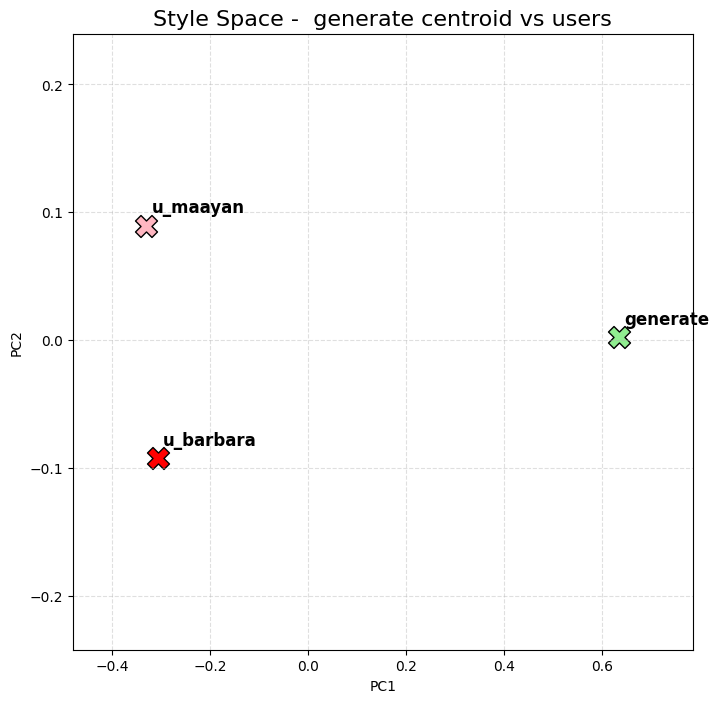

In [27]:
plot_centroids_only(centroids, title="Style Space -  generate centroid vs users")

### Evaluation and analysis of sentiment, lexicographic, 3chargram, emoji overlap

In [28]:
# simple word tokenizer
def _tokenize_words(text: str) -> List[str]:
    text = text.lower()
    # split on non letters or numbers
    return re.findall(r"\w+", text)


# character n grams
def _char_ngrams(text: str, n: int = 3) -> List[str]:
    text = text.replace(" ", "")
    if len(text) < n:
        return []
    return [text[i:i+n] for i in range(len(text) - n + 1)]


# simple emoji extractor
EMOJI_PATTERN = re.compile(
    r"[\U0001F300-\U0001FAFF\U00002600-\U000027BF]"
)

def _extract_emojis(text: str) -> List[str]:
    return EMOJI_PATTERN.findall(text)


In [ ]:
def _compute_lexical_jaccard(
    user_messages: List[str],
    generated_message: str
) -> float:
    """
    Computes the average Jaccard similarity of word unigrams between 
    the generated message and all user messages.
    """
    if not user_messages:
        return 0.0

    gen_tokens = set(_tokenize_words(generated_message))
    user_jaccards = []

    for msg in user_messages:
        user_tokens = set(_tokenize_words(msg))

 
        if not gen_tokens and not user_tokens:
            user_jaccards.append(0.0)
            continue
        

        inter = len(gen_tokens & user_tokens)
        union = len(gen_tokens | user_tokens) or 1 # 'or 1' prevents division by zero

        user_jaccards.append(inter / union)

    return float(np.mean(user_jaccards))

In [30]:
def _compute_char_3gram_jaccard(
    user_messages: List[str],
    generated_message: str
) -> float:
    """
    Computes the average Jaccard similarity of character trigrams (n=3) 
    between the generated message and all user messages.
    """
    if not user_messages:
        return 0.0

    gen_3grams = set(_char_ngrams(generated_message, n=3))
    char_jaccards = []

    for msg in user_messages:
        user_3grams = set(_char_ngrams(msg, n=3))

        if not gen_3grams and not user_3grams:
            char_jaccards.append(0.0)
            continue
        inter = len(gen_3grams & user_3grams)
        union = len(gen_3grams | user_3grams) or 1 
        char_jaccards.append(inter / union)

    return float(np.mean(char_jaccards))

In [32]:
def _compute_emoji_overlap(
    user_messages: List[str],
    generated_message: str
) -> float:
    """
    Computes the ratio of unique emojis in the generated message that were 
    also present in any of the user messages (Overlap = Intersection / Generated).
    """
    gen_emojis = set(_extract_emojis(generated_message))
    user_emojis_all = []

    for msg in user_messages:
        user_emojis_all.extend(_extract_emojis(msg))

    user_emojis = set(user_emojis_all)
    if len(gen_emojis) == 0:
        emoji_overlap = 0.0
    else:
        inter = len(gen_emojis & user_emojis)
        emoji_overlap = inter / len(gen_emojis)
        
    return emoji_overlap

In [34]:
def _compute_sentiment_similarity(
    user_id: str,
    user_messages: List[str],
    generated_message: str,
    sentiment_pipeline
) -> float:
    """
    Computes the cosine similarity of sentiment vectors, prints the style 
    analysis (centroid and generated message), and returns the score.
    """
    ordered_labels = None

    def _sent_vec(text: str) -> np.ndarray:
        nonlocal ordered_labels
    
        res = sentiment_pipeline(text, truncation=True)[0]
        
        if ordered_labels is None:
            res_sorted = sorted(res, key=lambda x: x['label'])
            ordered_labels = [item['label'] for item in res_sorted]
            scores = np.array([item["score"] for item in res_sorted], dtype=float)
            return scores
        else:
            score_map = {item['label']: item['score'] for item in res}
            aligned_scores = [score_map[label] for label in ordered_labels]
            return np.array(aligned_scores, dtype=float)


    user_sent_vecs = np.stack([_sent_vec(m) for m in user_messages])
    user_sent_centroid = user_sent_vecs.mean(axis=0)

    gen_sent_vec = _sent_vec(generated_message)

    
    user_centroid_dict = {
        label : user_sent_centroid[i] * 100
        for i, label in enumerate(ordered_labels)
    }  

    gen_sent_dict = {
        label: gen_sent_vec[i] * 100
        for i, label in enumerate(ordered_labels)
    }
    
    sentiment_cos = cosine_similarity(
        user_sent_centroid.reshape(1, -1),
        gen_sent_vec.reshape(1, -1)
    )[0][0]

    return float(sentiment_cos), user_centroid_dict, gen_sent_dict

In [35]:
def compute_style_metrics(
    user_id: str,
    user_messages: List[str],
    generated_message: str,
    sentiment_pipeline=None
) -> Dict[str, float]:
    """
    Compute several style metrics between a set of user messages
    and a single generated message.

    Metrics:
      - lexical_jaccard: Jaccard overlap of word unigrams
      - char_3gram_jaccard: Jaccard overlap of character trigrams
      - emoji_overlap: overlap between emojis of user and generated
      - sentiment_cosine: cosine similarity between average user sentiment
        and sentiment of generated message (requires sentiment_pipeline)
    """
    lexical_jaccard = _compute_lexical_jaccard(user_messages, generated_message)
    char_3gram_jaccard = _compute_char_3gram_jaccard(user_messages, generated_message)
    emoji_overlap = _compute_emoji_overlap(user_messages, generated_message)
    sentiment_cos = None
    if sentiment_pipeline is not None:
        sentiment_cos, user_centroid_str, gen_sent_str = _compute_sentiment_similarity(
            user_id,
            user_messages, 
            generated_message, 
            sentiment_pipeline  # Pass the model pipeline
        )

    return {
        "lexical_jaccard": lexical_jaccard,
        "char_3gram_jaccard": char_3gram_jaccard,
        "emoji_overlap": emoji_overlap,
        "sentiment_cosine": float(sentiment_cos) if sentiment_cos is not None else None
    }, user_centroid_str, gen_sent_str

In [36]:
from transformers import pipeline
          # list of strings

sent_pipe = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    return_all_scores=True
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [41]:
gen_msg = response.text            

metrics_barbara, barbara_centroid_dict,gen_sent_dict = compute_style_metrics(
    'u_barbara',
    user_messages=barbara_messages,
    generated_message=gen_msg,
    sentiment_pipeline=sent_pipe
)

metrics_maayan, maayan_centroid_dict,_ = compute_style_metrics(
    'u_maayan',
    user_messages=maayan_messages,
    generated_message=gen_msg,
    sentiment_pipeline=sent_pipe
)

print("\n--- Sentiment Style Analysis ---\n")

sentimend_data = {
    'Barbara_Sentiment': barbara_centroid_dict,
    'Maayan_Sentiment': maayan_centroid_dict,
    }

metrics_data = {
    'Barbara_Metrics': metrics_barbara,
    'Maayan_Metrics': metrics_maayan,
    }

df_sentiment = pd.DataFrame(sentimend_data)
df_sentiment_transposed = df_sentiment.T
display(df_sentiment_transposed)

df = pd.DataFrame(metrics_data)
df_transposed = df.T
display(df_transposed)


--- Sentiment Style Analysis ---



,negative,neutral,positive
Barbara_Sentiment,21.862171,48.713772,29.424058
Maayan_Sentiment,19.119584,49.819008,31.061408


,lexical_jaccard,char_3gram_jaccard,emoji_overlap,sentiment_cosine
Barbara_Metrics,0.034641,0.015524,0.0,0.498959
Maayan_Metrics,0.036511,0.015502,0.0,0.519410
